In [1]:
from loader.mnist import MNIST, MNIST_NORMALIZATION
from loader.emnist import EMNIST
from loader.fmnist import FashionMNIST
from core.cnn import simple_cnn
from core.maha import maha_distance
from torchvision import datasets,transforms
import torch
from core.sngp import SNGP_module
import numpy as np
from core.score import plot, plot_confidence_hist, histogram_binning_calibrator
import matplotlib.pyplot as plt

In [2]:
tf = transforms.Compose([
            transforms.ToTensor(),
            MNIST_NORMALIZATION,
        ])
train_data = MNIST('./dataset/',download=True,transform=tf)
test_id = MNIST('./dataset/', download=True,transform=tf,train=False)
val_id = MNIST('./dataset/', download=True,transform=tf,train=True,val=True)
test_near_ood = EMNIST('./dataset/',download=True,transform=tf,train=False,split='letters')
test_far_ood = FashionMNIST('./dataset/',download=True,transform=tf,train=False)

train_loader = torch.utils.data.DataLoader(train_data,batch_size = 128,shuffle=True)
val_id_loader = torch.utils.data.DataLoader(val_id,batch_size = 128,shuffle=False)
test_id_loader = torch.utils.data.DataLoader(test_id,batch_size = 128,shuffle=False)
test_near_ood_loader = torch.utils.data.DataLoader(test_near_ood,batch_size = 128,shuffle=False)
test_far_ood_loader = torch.utils.data.DataLoader(test_far_ood,batch_size = 128,shuffle=False)

In [3]:
model = SNGP_module(y_dim = 10,h_dims=[128,32]).to('cuda:0')
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.1, weight_decay=1e-5)


In [4]:
for e in range(5):
    for image,label in train_loader:
        out = model(image.to('cuda'))
        # print(out.shape,label)
        loss = criterion(out,label.to('cuda'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss)

tensor(0.3644, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3619, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2391, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2410, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1606, device='cuda:0', grad_fn=<NllLossBackward>)


In [5]:
for image,label in train_loader:
    out = model(image.to('cuda'), update = True)

## Test

In [6]:
model.eval()
y_true = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_id_loader:
        out = model(image.to('cuda'))
        _,pred_logit = torch.max(out,dim=-1)
        y_true += (label==pred_logit.cpu()).numpy().tolist()
        num_acc += (label == pred_logit.cpu()).sum().item()
        total += label.shape[0]
print("Accuracy:{}".format(num_acc/total))

Accuracy:0.9853


## Uncertainty

In [7]:
model.eval()
id_score = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_id_loader:
        out,en = model.inference(image.to('cuda'))
        id_score += en.cpu().numpy().tolist()
id_score = np.asarray(id_score)
print(id_score.mean())

near_ood_score = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_near_ood_loader:
        out,en = model.inference(image.to('cuda'))
        near_ood_score += en.cpu().numpy().tolist()
near_ood_score = np.asarray(near_ood_score)
print(near_ood_score.mean())

far_ood_score = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_far_ood_loader:
        out,en = model.inference(image.to('cuda'))
        far_ood_score += en.cpu().numpy().tolist()
far_ood_score = np.asarray(far_ood_score)
print(far_ood_score.mean())

0.04222520761257038
0.21424219308044903
0.23905673913564532


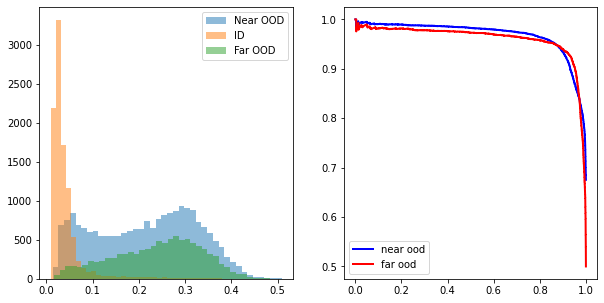

Near AUROC:0.9451444254807693, Far AUROC: 0.9688358399999999


In [8]:
auroc = plot(id_score,near_ood_score,far_ood_score,name='Energy Based',reverse=False)
print("Near AUROC:{}, Far AUROC: {}".format(auroc[0],auroc[1]))

## Calibration

In [10]:
model.eval()
val_y_true,val_score = [], []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in val_id_loader:
        out,en = model.inference(image.to('cuda'))
        _,pred_logit = torch.max(out,dim=-1)
        val_score += en.cpu().numpy().tolist()
        val_y_true += (label==pred_logit.cpu()).numpy().tolist()
        num_acc += (label == pred_logit.cpu()).sum().item()
        total += label.shape[0]
print("Accuracy:{}".format(num_acc/total))
val_score = np.asarray(val_score)

Accuracy:0.9871666666666666


In [12]:
val_score.shape

(6000,)

ECE(%):  0.09110120304751602


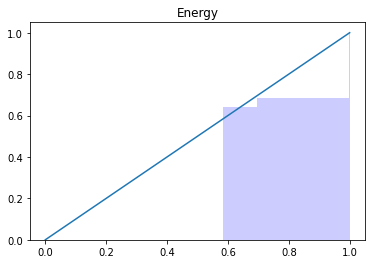

In [13]:
cval_score_en = val_score*-1
cid_score_en = id_score* -1
min_en= cval_score_en.min() -1 
max_en = cval_score_en.max() +1
cal = histogram_binning_calibrator(15,min_en, max_en)
cal.fit(cval_score_en,val_y_true)
prob_pred, prob_true, ece = cal.inference(cid_score_en, y_true)

plot_confidence_hist(prob_true,prob_pred,'Energy')